# Darcy Flow
Including forward and inverse problem solver for 1D. Darcy Flow
Darcy Flow
\begin{equation}
    \nabla \cdot ( k(x) \nabla u(x) ) = f(x)
\end{equation}

Zero Dirichlet boundary conditions $u(0) = u(1) = 0$

## Hints from Tim Sullivan

Express $u$ as $u(x) = \sum_{j = 1}^{n} u_{j} \phi_{j}(x)$ with $\phi_{j}(x) =$ piecewise linear tent function peaking at node $j$

Solve $A(u_{1}, …, u_{n}) = b$ for the coefficients  
\begin{align}
b_{j} &= \int_{0}^{1} f(x) \phi_{j}(x) d x \\
A_{i j} &= \int_{0}^{1} k(x) \phi'_{i}(x) \phi'_{j}(x) d x
\end{align}
Google finite element method / Galerkin method for elliptic PDE 

I will give you e.g. (u(1/4), u(1/2), u(3/4)) and similarly for f, both corrupted by additive N(0, \sigma^{2}) noise.
Your challenge:  infer k

--

Modelling assumption:  $k(x) = exp( \sum_{\alpha = 0}^{A} k_{\alpha} \phi_{\alpha}(x) )$

--

Try a Fourier basis. Note that u vanishes at the boundary, but that doesn't mean k does.

Create the forward model. Solver works. Extend to imitation inverse model with likelihood, etc. Use this to solve his problem.


# The Darcy Flow Problem

We consider the Darcy Flow problem in one dimension with Dirichlet boundry conditions and a modeling assumption.

\begin{align}
    k'(x) u'(x) + k(x) u''(x) &= f(x) \\
    u(0) = u(1) &= 0 \\
    exp( \sum_{\alpha = 0}^{A} k_{\alpha} \phi_{\alpha}(x) ) &=  k(x)
\end{align}

We put the equation into the weak form. $v(x)$ is a function which satisfies the boundary conditions.

\begin{equation}
    \int_{0}^{1} f(x)v(x) \ dx = \int_{0}^{1} (k'(x) u'(x) v(x) + k(x) u''(x) v(x)) \ dx
\end{equation}

We can integrate by parts and apply our boundry conditions on the second R.H.S. term to arrive at the next equation.

\begin{align}
    \int_{0}^{1} f(x)v(x) \ dx &= \int_{0}^{1} k'(x) u'(x) v(x) \ dx +
                                  k(x) u'(x) v(x) |_{0}^{1} - 
                                  \int_{0}^{1} k'(x) u'(x) v(x) \ dx - 
                                  \int_{0}^{1} k(x) u'(x) v'(x) \ dx \\
    \int_{0}^{1} f(x)v(x) \ dx &= - \int_{0}^{1} k(x) u'(x) v'(x) \ dx
\end{align}

We choose the piecewise linear function $v_k$ for a discretization.

\begin{equation}
v_{k}(x) = 
    \begin{cases}
        \frac{x-x_{k-1}}{x_k-x_{k-1}} & \text{if } x \in [x_{k-1}, x_k] \\
        \frac{x_{k+1}-x}{x_{k+1}-x_k} & \text{if } x \in [x_{k}, x_{k+1}] \\
        0 & \text{otherwise}
    \end{cases}
\end{equation}

If we expand $u(x)$ in a basis of tent functions on this discretization, we are left with the problem

\begin{equation}
    A \bf{u} = \bf{b}
\end{equation}

where $A_{ij} = - \int_{0}^{1} k(x) v_{i}'(x) v_{j}'(x) \ dx$ and $b_{j} = \int_{0}^{1} f(x) v_{j} dx$. Note that this will be a sparse matrix due our use of tent functions. With our modeling assumption, only 

## Useful Links
https://en.wikipedia.org/wiki/Finite_element_method  
http://www.mathematik.uni-dortmund.de/~kuzmin/Transport.pdf  

# Forward Solver

In [27]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

np.random.seed(31)

In [28]:
def grid(nodes):
    return np.linspace(0, 1, num=nodes)
    
def tent(x, k, grid):
    def down(x):
        return (grid[k+1] - x) / (grid[k+1] - grid[k])
    def up(x):
        return (x - grid[k-1]) / (grid[k] - grid[k-1])
    if (k < 0) or (k > grid.size - 1):
        raise ValueError('k was not in [0, grid.size - 1]')
    elif k == 0:
        if (grid[k] <= x) and (x <= grid[k+1]):
            return down(x)
        else:
            return 0
    elif k == grid.size - 1:
        if (grid[k-1] <= x) and (x <= grid[k]):
            return up(x)
        else:
            return 0
    else:
        if (grid[k-1] <= x) and (x <= grid[k]):
            return up(x)
        elif (grid[k] <= x) and (x <= grid[k+1]):
            return down(x)
        else:
            return 0
        
def κ(x, coefs, grid):
    lo_bound = np.searchsorted(grid, x, 'left')
    up_bound = np.searchsorted(grid, x, 'right')
    
    if (0 - 0.1 <= x) and (x < grid[1]):
        return np.exp(sum([coefs[0] * tent(x, 0, grid), coefs[1] * tent(x, 1, grid)]))
    elif (grid[-2] < x) and (x <= grid[-1] + 0.1):
        return np.exp(sum([coefs[-2] * tent(x, grid.size - 2, grid), coefs[-1] * tent(x, grid.size - 1, grid)]))
    else:
        return np.exp(sum([coefs[k] * tent(x, k, grid) for k in [lo_bound, up_bound]]))
    
# def kappa(x, coefs, grid):
#     return np.exp(sum([coefs[k] * tent(x, k, grid) for k in range(grid.size)]))

def A(k, grid):
    val = lambda x, y: scipy.integrate.quad(k, x, y, limit=100)[0]
    lo_di = np.asarray([ val(grid[i-1], grid[i]  ) for i in range(2, grid.size - 1)])
    di    = np.asarray([-val(grid[i-1], grid[i+1]) for i in range(1, grid.size - 1)])
    up_di = np.asarray([ val(grid[i]  , grid[i+1]) for i in range(1, grid.size - 2)])
    
    return np.sum([np.diag(lo_di, -1), np.diag(di), np.diag(up_di, 1)], axis=0)

def b(f, grid):
    val = lambda x, y: scipy.integrate.quad(f, x, y)[0]
    return np.asarray([-val(grid[i-1], grid[i+1]) for i in range(1, grid.size - 1)])

# Plot of basis set and parameters

The triangluar basis is plotted along with the parameter vector taking to the expotential.

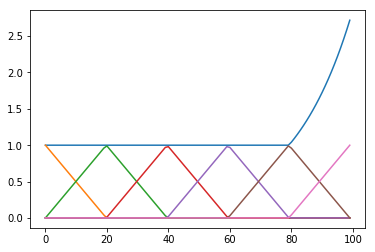

In [29]:
nodes = 6
g = grid(nodes)
plt.plot([κ(x, np.array([0,0,0,0,0,1]), g) for x in np.linspace(0, 1, num=100)])

for i in range(nodes):
    plt.plot([tent(x, i, g) for x in np.linspace(0, 1, num=100)])
plt.show()

# Forward Solver Test

Using a numpy solver, we can create solutions given the parameters and basis set.

In [30]:
nodes = 8
pars = np.random.randn(nodes)
g = grid(nodes)
aa = A(lambda x: κ(x, pars, g), g)
bb = b(lambda x: 1, g)

print(aa)
print(bb)
print(np.linalg.solve(aa, bb))

[[-0.25339759  0.15509423  0.          0.          0.          0.        ]
 [ 0.15509423 -0.22683167  0.07173744  0.          0.          0.        ]
 [ 0.          0.07173744 -0.18746018  0.11572273  0.          0.        ]
 [ 0.          0.          0.11572273 -0.18897495  0.07325221  0.        ]
 [ 0.          0.          0.          0.07325221 -0.14574055  0.07248834]
 [ 0.          0.          0.          0.          0.07248834 -0.39317869]]
[-0.28571429 -0.28571429 -0.28571429 -0.28571429 -0.28571429 -0.28571429]
[ 8.43791319 11.94391668 15.54101477 15.30192896 11.02380644  2.75908052]


# Inverse Problem

Given our Darcy Flow system, some coefficents of $u_{i}$ corrupted by additive noise $\mathcal{N}(0, \sigma^{2})$, and knowledge of $f(x)$, it is our job to infer the paramters $k_{\alpha}$. 

This section referse to a case where:

\begin{equation}
    - \frac{d}{dx}(e^{u(x)} \frac{dp}{dx}(x)) = f(x)
\end{equation}

Data, In this case, we assume we have 3 data points:

\begin{align}
    y &= [u(x_{1}), u(x_{4}), u(x_{9})] + \mathcal{N}(0, \sigma^{2})
\end{align}

Centered gaussian prior on u:

\begin{equation}
    \text{log prior density}(u) = - \sum_{k=1}^{A} \rho_k^2 (u_k)^2, \rho_k \sim \frac{1}{k}
\end{equation}

Write G for the u-to-y map, $G: \mathbb{R}^K \rightarrow \mathbb{R}^3$. (3 because we have 3 data points.)

\begin{equation}
    G(u) = [u(x_{1}), u(x_{4}), u(x_{9})]
\end{equation}

Gaussian observerd noise:

\begin{equation}
    \text{log likelihood}(u) = - \frac{1}{2 \sigma^2} ||G(u) - y||_{\mathbb{R}^3, 2}^{2}
\end{equation}

Log posterior to sample from (u|y)

\begin{equation}
    \text{log posterior}(u|y) = - \frac{1}{2 \sigma^2} ||G(u) - y||_{\mathbb{R}^3, 2}^{2} + \sum_{k=1}^{A} \rho_k^2 u_k^2
\end{equation}

The functions below use notation consistent with the forward solver

In [31]:
import scipy.stats
import seaborn as sns
import pandas as pd

In [32]:
# Random Walk MCMC Function
def metropolis_step(state, proposal_dist, target_dist):
    proposed_state = state + proposal_dist.rvs()

    acceptance_prob = min([0, target_dist(proposed_state) - target_dist(state)])

    if acceptance_prob > 0 or np.log(np.random.rand()) <= acceptance_prob:
        return proposed_state
    else:
        return state

In [33]:
def G_pre(k, f, grid):
    """(almost) Returns a vector of the forward solver given the vector of k_alphas."""
    aa = A(lambda x: κ(x, k, grid), grid)
    bb = b(f, grid)

    return aa, bb

def spec_metropolis_step(state, data, data_inds, noise_sigma, prop_sigma, prior_sigma, f, grid, verbose=False):
    def GG(f, grid):
        def gg(k):
            aa, bb = G_pre(k, f, grid)
            return np.linalg.solve(aa, bb)
        return gg
    
    G = GG(f, grid)
    
    proposal_dist = scipy.stats.multivariate_normal(np.zeros_like(grid),
                                                    np.eye(grid.shape[0]) * prop_sigma ** 2)
    proposed_state = state + proposal_dist.rvs()
    
#     alpha = (np.linalg.norm(data - G(state)[data_inds]) ** 2 -
#              np.linalg.norm(data - G(proposed_state)[data_inds]) ** 2) / (2 * noise_sigma ** 2)
#     alpha += (np.linalg.norm(state) ** 2 - np.linalg.norm(proposed_state)) / (2 * prop_sigma ** 2)

    err_state = np.linalg.norm(data - G(state)[data_inds]) ** 2
    err_props = np.linalg.norm(data - G(proposed_state)[data_inds]) ** 2
    norm_state = np.linalg.norm(state) ** 2
    norm_props = np.linalg.norm(proposed_state) ** 2

    if verbose:
        print('')
    
    alpha = (err_state - err_props) / (2 * noise_sigma ** 2) + (norm_state - norm_props) / (2 * prior_sigma ** 2)
    
#     alpha = (
#         (np.linalg.norm(data - G(state)[data_inds]) ** 2 -
#          np.linalg.norm(data - G(proposed_state)[data_inds]) ** 2) / (2 * noise_sigma ** 2) +
#         (np.linalg.norm(state) ** 2 - np.linalg.norm(proposed_state)) / (2 * prior_sigma ** 2)
#     )
    
    if alpha > 0 or np.log(np.random.rand()) <= alpha:
        return proposed_state
    else:
        return state
    

def target(data, data_inds, prior_k, prior_sigma, noise_sigma, f, grid):
    def logposterior(x):
        aa, bb = G_pre(x, f, grid)
        return -( 
            (1/(2 * noise_sigma**2) * (np.linalg.solve(aa, bb)[data_inds] - data) + 
             prior_k.norm / (2 * prior_sigma**2))
        )
    return logposterior

In [34]:
def pairplotit(df):
    def addline(x, *args, **kwargs):
        def removekey(d, key):
            r = dict(d)
            del r[key]
            return r
        if kwargs['label'] == 'data':
            kwargs = removekey(kwargs, 'color')
            return plt.axvline(x.mean(), color='orange', linestyle='dashed', linewidth=3, **kwargs)
        else:
            pass
        
    g = sns.PairGrid(df, hue='type')
    g = g.map_diag(plt.hist)
    g = g.map_diag(addline)
    g = g.map_offdiag(plt.scatter)
    g = g.add_legend()
    plt.show()

# Synthetic Data Generation

We will solve a system with a randomly generated parameter vector. Later, we will use that solution to attempt to recover the parameter vector. (In a case of under, exactly, and over determined data.)

[ 8.46746867 14.43252649 18.62731742 20.98468203 21.1381103  19.49243266
 15.49932492  8.54868027]


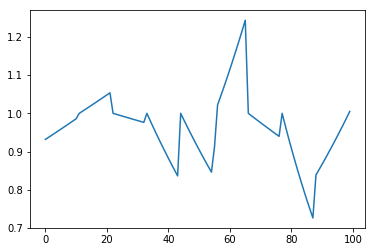

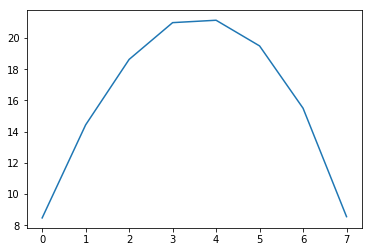

In [35]:
nodes = 10
param_distribution_sigma = 1/nodes
pars = param_distribution_sigma * np.random.randn(nodes)
g = grid(nodes)

k = lambda x: κ(x, pars, g)
f = lambda x: 1

aa = A(k, g)
bb = b(f, g)

soln = np.linalg.solve(aa, bb)
print(soln)

u = np.asarray([[x, k(x)] for x in np.linspace(0, 1, num=100)])
plt.plot(u[:, 1])
plt.show()
plt.plot(soln)
plt.show()

noise_sigma = 1
noise = lambda: np.random.randn(1) * noise_sigma

# Recover k in an underdetermined system

Given only three data points, recover the paramters with a gaussian prior around zero.

In [36]:
data_inds = [0, 3, 7]
data = np.asarray([[g[i + 1], soln[i]] for i in data_inds])

corruption_sigma = 1

corrupted_data = data.copy()
corrupted_data[:, 1] += corruption_sigma * np.random.randn(len(data_inds))

print(data, '\n', corrupted_data)

[[ 0.11111111  8.46746867]
 [ 0.44444444 20.98468203]
 [ 0.88888889  8.54868027]] 
 [[ 0.11111111  7.89553967]
 [ 0.44444444 20.28411599]
 [ 0.88888889  7.61357403]]


In [37]:
states = [np.zeros_like(g)]
steps = 5000

noise_sigma = 1
prop_sigma = 1/nodes ** 2
prior_sigma = 1/nodes

for i in range(steps):
    try:
        states.append(spec_metropolis_step(states[-1], 
                                           corrupted_data[:, 1],
                                           data_inds,
                                           noise_sigma,
                                           prop_sigma,
                                           prior_sigma,
                                           f,
                                           g))
    except np.linalg.LinAlgError:
        continue
    
states = np.asarray(states)

In [38]:
df = pd.DataFrame(states)
df.loc[:, 'type'] = pd.Series(['sample'] * df.shape[0], index=df.index)
df2 = pd.DataFrame(pars[:, np.newaxis].T, columns=df.columns[:-1])
df2.loc[:, 'type'] = pd.Series(['data'])
df = df.append(df2, ignore_index=True)

Below are our plotted samples. The true parameter value is plotted in orange as a dotted line or a data point.

Given 1000 samples, our prior still plays a major role in the location of the samples. Many samples are clustered around zero with some peaks elsewhere.

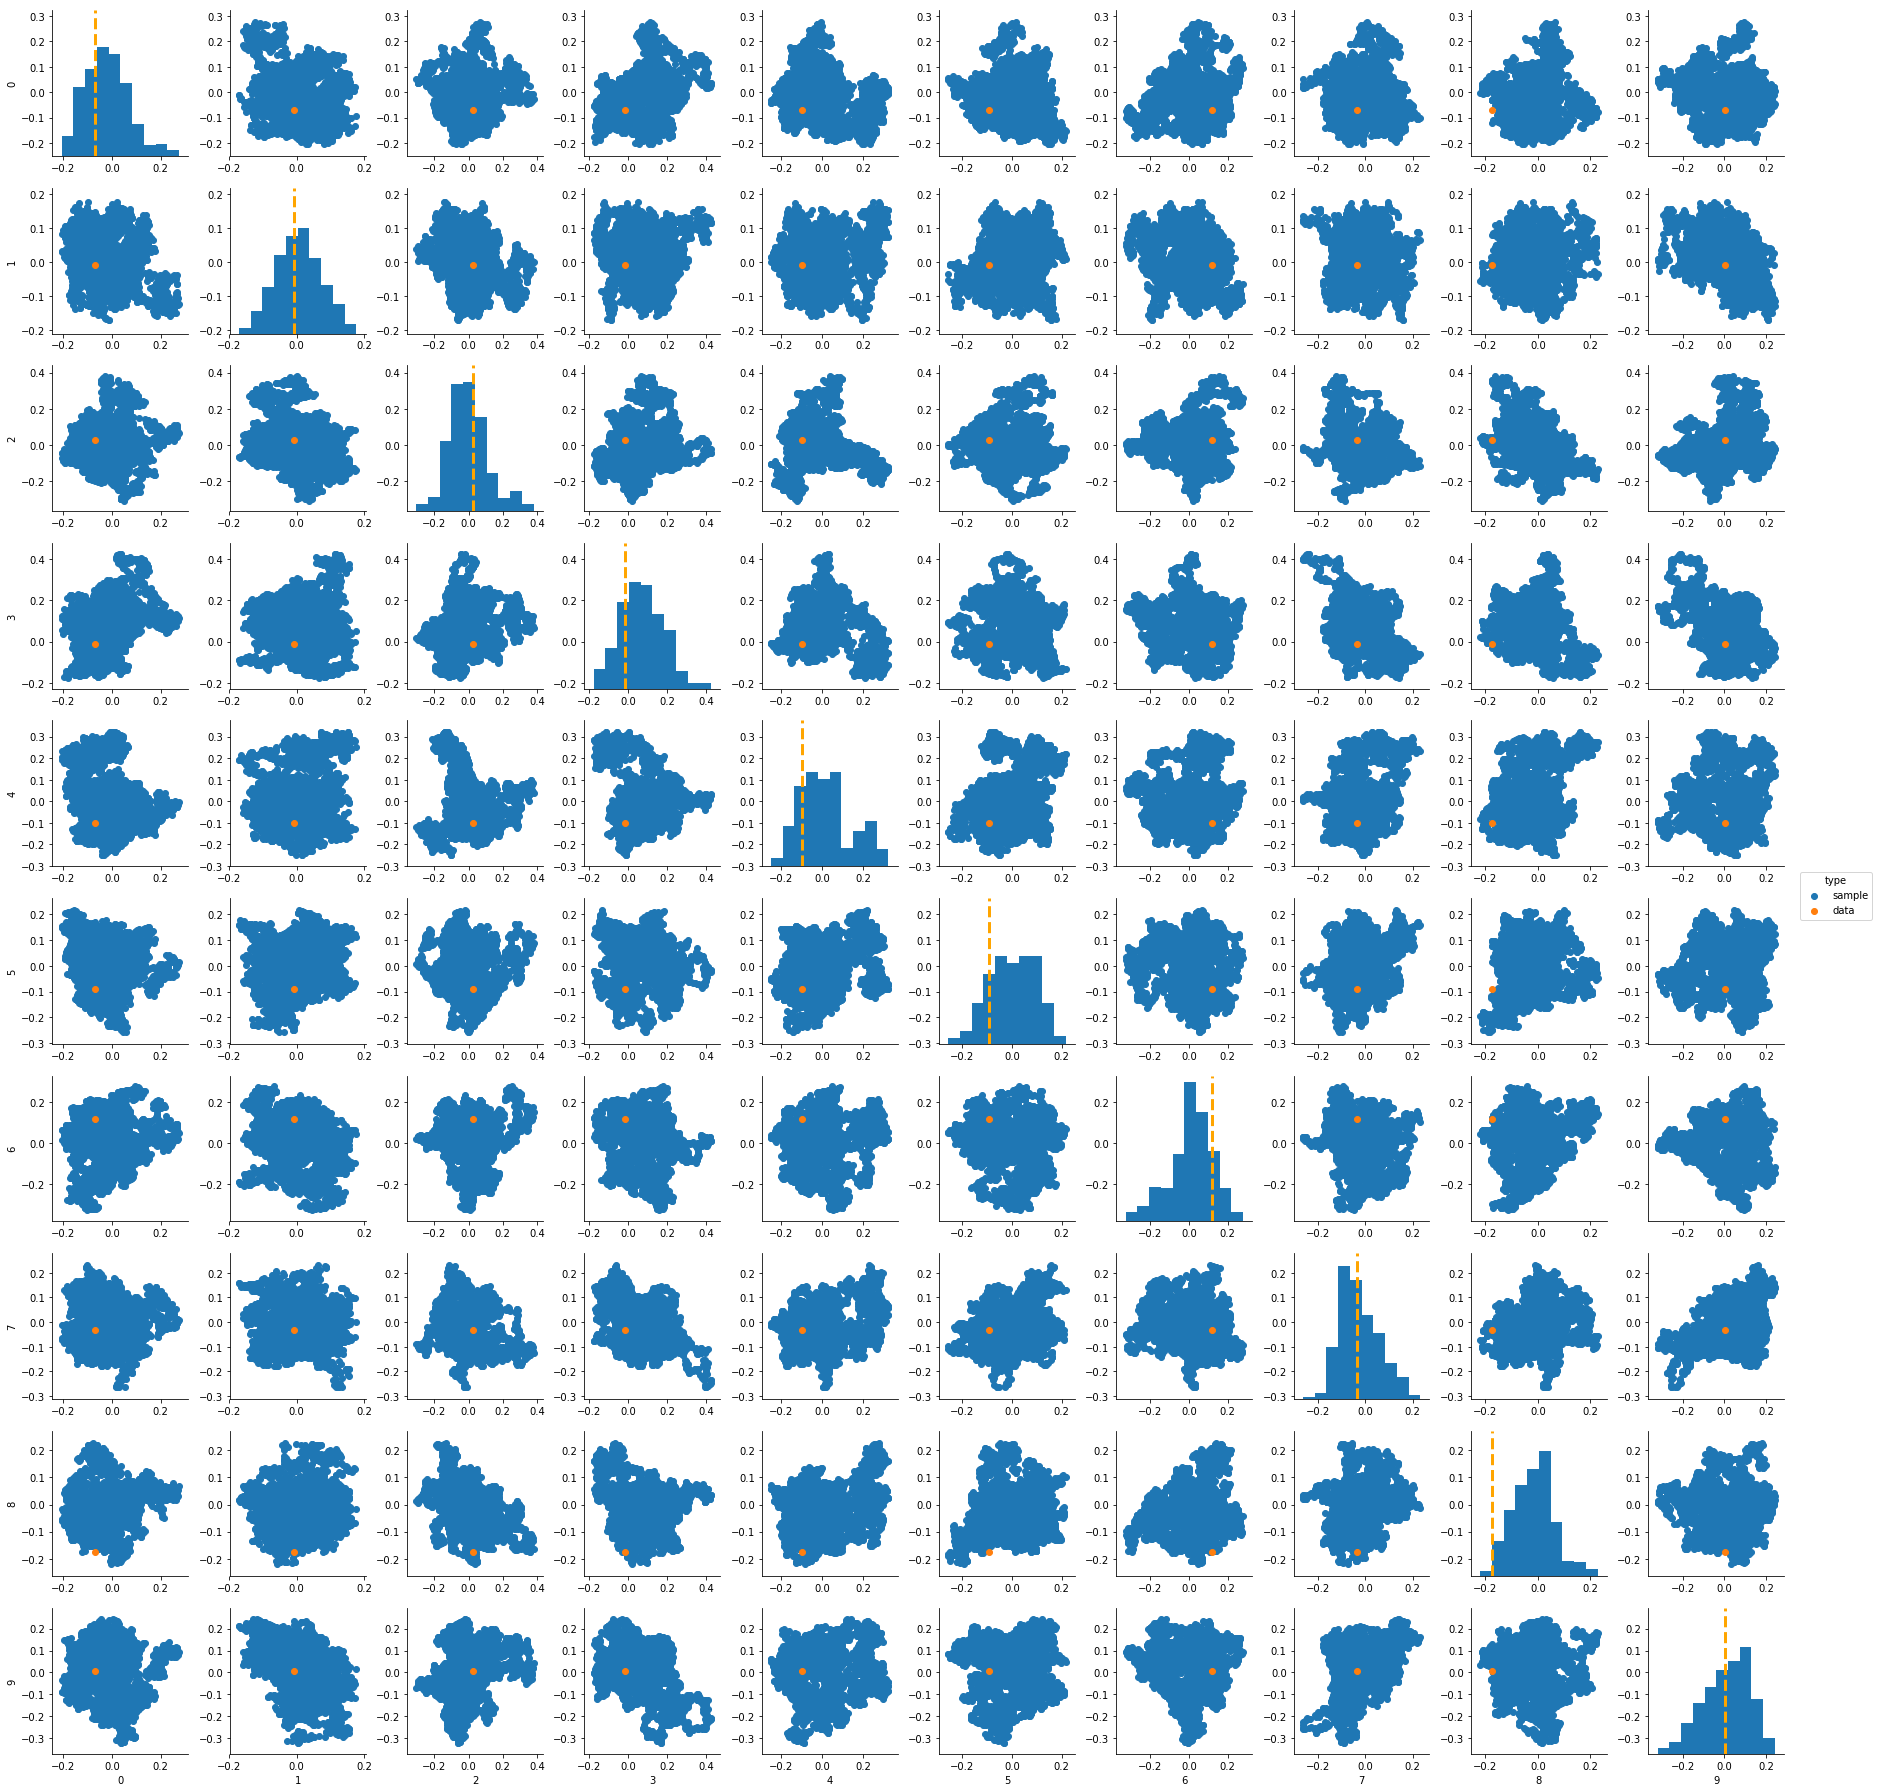

In [39]:
pairplotit(df)

# Recover k in system with a "fully determined" data set

Given eight data points, recover the paramters with a gaussian prior around zero. In this case, we have the same number of data points as we do intermediate nodes between the boundry conditions.

In [40]:
data_inds = list(range(len(g) - 2)) # [0, 3, 7]
data = np.asarray([[g[i + 1], soln[i]] for i in data_inds])

corruption_sigma = 1

corrupted_data = data.copy()
corrupted_data[:, 1] += corruption_sigma * np.random.randn(len(data_inds))

print(data, '\n', corrupted_data)

[[ 0.11111111  8.46746867]
 [ 0.22222222 14.43252649]
 [ 0.33333333 18.62731742]
 [ 0.44444444 20.98468203]
 [ 0.55555556 21.1381103 ]
 [ 0.66666667 19.49243266]
 [ 0.77777778 15.49932492]
 [ 0.88888889  8.54868027]] 
 [[ 0.11111111  8.95385972]
 [ 0.22222222 15.00555611]
 [ 0.33333333 18.37349419]
 [ 0.44444444 19.3375764 ]
 [ 0.55555556 22.04375296]
 [ 0.66666667 20.28455611]
 [ 0.77777778 15.71882963]
 [ 0.88888889  7.0096151 ]]


In [41]:
states = [np.zeros_like(g)]
steps = 5000

noise_sigma = 1
prop_sigma = 1/nodes ** 2
prior_sigma = 1/nodes

for i in range(steps):
    try:
        states.append(spec_metropolis_step(states[-1], 
                                           corrupted_data[:, 1],
                                           data_inds,
                                           noise_sigma,
                                           prop_sigma,
                                           prior_sigma,
                                           f,
                                           g))
    except np.linalg.LinAlgError:
        continue
    
states = np.asarray(states)

In [42]:
df = pd.DataFrame(states)
df.loc[:, 'type'] = pd.Series(['sample'] * df.shape[0], index=df.index)
df2 = pd.DataFrame(pars[:, np.newaxis].T, columns=df.columns[:-1])
df2.loc[:, 'type'] = pd.Series(['data'])
df = df.append(df2, ignore_index=True)

# sns.pairplot(df, hue='type')
# plt.show()
# # plt.savefig('8_data_pts', format=None)

Below are our plotted samples. The true parameter value is plotted in orange as a dotted line or a data point.

Given 5000 samples, with the exactly determined data set, most of our clusters have moved away from zero. The peaks are nearly at the parameter values, but sometimes the MCMC got stuck on one side.

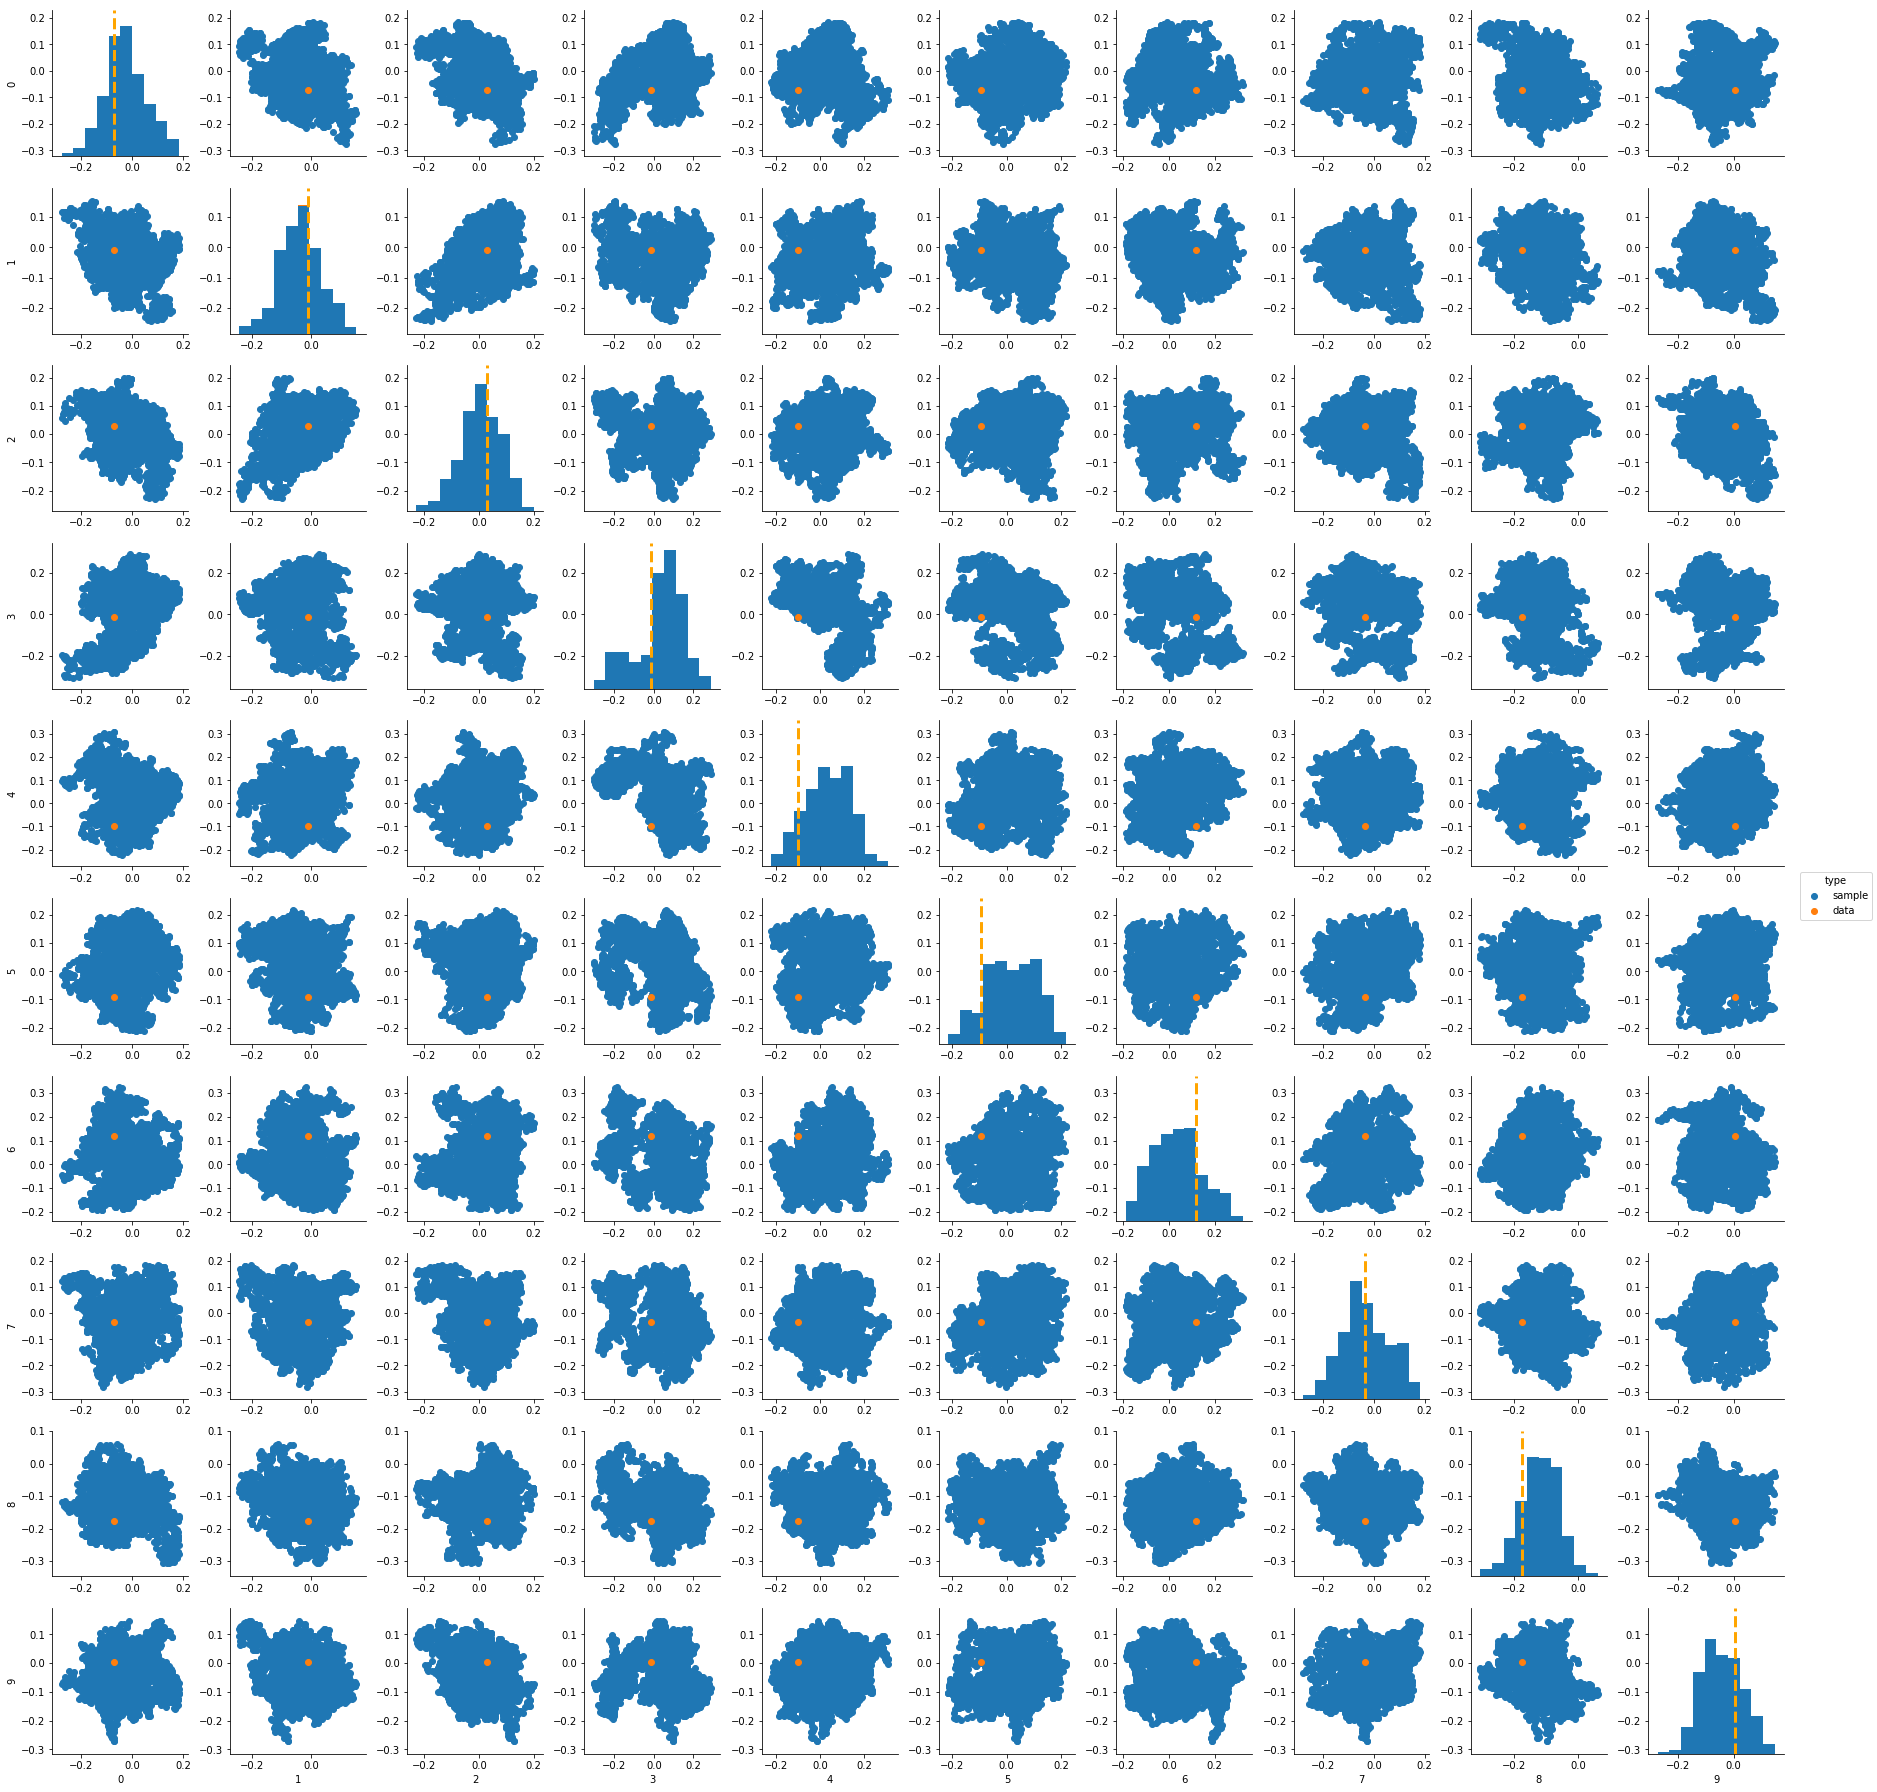

In [43]:
pairplotit(df)

# Recover k in an overdetermined system

Given 16 data points, recover the paramters with a gaussian prior around zero. Now we have two copies of data at every node. This is possible due to the corruptive noise added to each term.

In [44]:
data_inds = list(range(len(g) - 2)) * 2 # [0, 3, 7]
data = np.asarray([[g[i + 1], soln[i]] for i in data_inds])

corruption_sigma = 1

corrupted_data = data.copy()
corrupted_data[:, 1] += corruption_sigma * np.random.randn(len(data_inds))

print(data, '\n', corrupted_data)

[[ 0.11111111  8.46746867]
 [ 0.22222222 14.43252649]
 [ 0.33333333 18.62731742]
 [ 0.44444444 20.98468203]
 [ 0.55555556 21.1381103 ]
 [ 0.66666667 19.49243266]
 [ 0.77777778 15.49932492]
 [ 0.88888889  8.54868027]
 [ 0.11111111  8.46746867]
 [ 0.22222222 14.43252649]
 [ 0.33333333 18.62731742]
 [ 0.44444444 20.98468203]
 [ 0.55555556 21.1381103 ]
 [ 0.66666667 19.49243266]
 [ 0.77777778 15.49932492]
 [ 0.88888889  8.54868027]] 
 [[ 0.11111111  7.42227223]
 [ 0.22222222 14.72654147]
 [ 0.33333333 19.69182956]
 [ 0.44444444 20.92112382]
 [ 0.55555556 21.63167916]
 [ 0.66666667 19.87140291]
 [ 0.77777778 14.39070157]
 [ 0.88888889  8.40080912]
 [ 0.11111111 10.22263209]
 [ 0.22222222 16.94375273]
 [ 0.33333333 18.42387617]
 [ 0.44444444 18.37375218]
 [ 0.55555556 21.41713904]
 [ 0.66666667 21.25490777]
 [ 0.77777778 14.58807225]
 [ 0.88888889 10.55092631]]


In [45]:
states = [np.zeros_like(g)]
steps = 5000

noise_sigma = 1
prop_sigma = 1/nodes ** 2
prior_sigma = 1/nodes

for i in range(steps):
    try:
        states.append(spec_metropolis_step(states[-1], 
                                           corrupted_data[:, 1],
                                           data_inds,
                                           noise_sigma,
                                           prop_sigma,
                                           prior_sigma,
                                           f,
                                           g))
    except np.linalg.LinAlgError:
        continue
    
states = np.asarray(states)

In [46]:
df = pd.DataFrame(states)
df.loc[:, 'type'] = pd.Series(['sample'] * df.shape[0], index=df.index)
df2 = pd.DataFrame(pars[:, np.newaxis].T, columns=df.columns[:-1])
df2.loc[:, 'type'] = pd.Series(['data'])
df = df.append(df2, ignore_index=True)

# sns.pairplot(df, hue='type')
# plt.show()
# # plt.savefig('8_data_pts', format=None)

Below are our plotted samples. The true parameter value is plotted in orange as a dotted line or a data point.

Given 5000 samples, the peaks are near to actual parameter values. Certainly the best so far

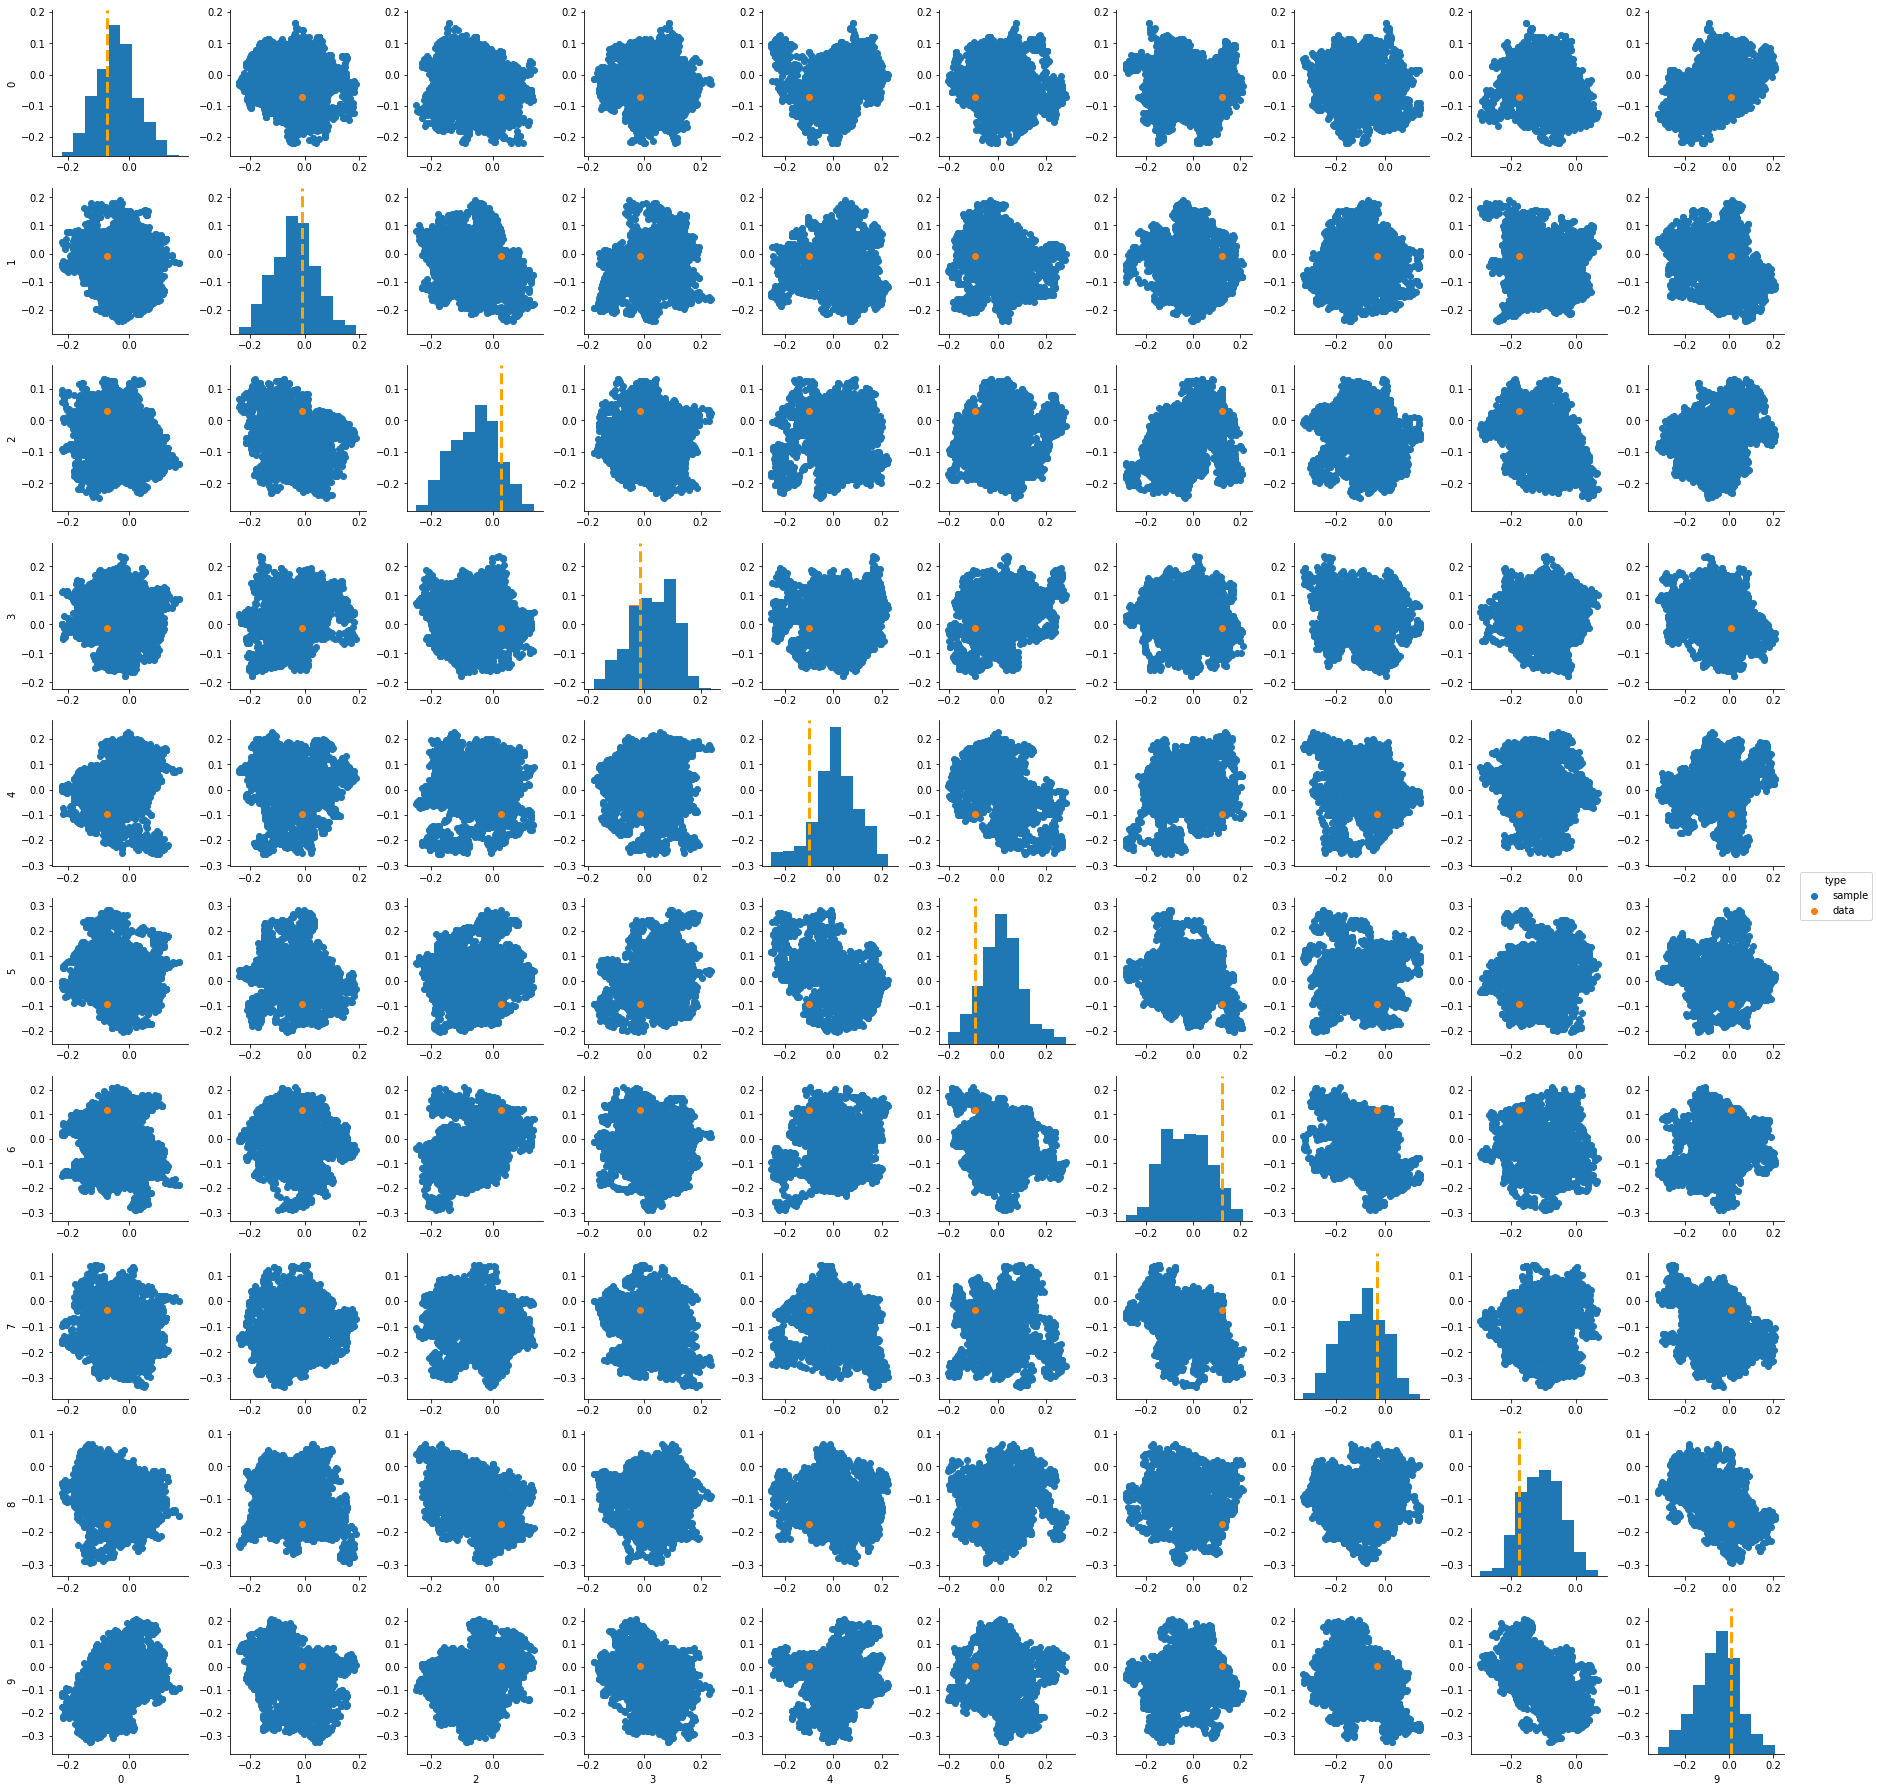

In [47]:
pairplotit(df)

# Extras

In [48]:
print(pars)

print(states.mean(axis=0))
print(np.abs(pars - states.mean(axis=0))/pars)

[-0.07056003 -0.0086042   0.02879333 -0.01313865 -0.09827442 -0.09187913
  0.11994345 -0.03413742 -0.17586073  0.00511175]
[-0.03958624 -0.03542069 -0.05707861  0.02954983  0.00922186  0.01707856
 -0.03072979 -0.09530319 -0.10494771 -0.05523559]
[-0.43897074 -3.11667323  2.98235523 -3.24907647 -1.09383781 -1.18588078
  1.25620236 -1.79175109 -0.40323396 11.80561856]


In [49]:
import pickle

if 0:
    pickle.dump( states, open( "samples_c.p", "wb" ) )

In [50]:
# smp = pickle.load( open( "samples_b.p", "rb" ) )
# smp = np.array(smp)
# smp